Using device: cuda

--- Preparing EuroSAT Dataset ---


100%|██████████| 94.3M/94.3M [00:00<00:00, 252MB/s]


EuroSAT loaded: 21600 train, 5400 test images.

--- Evaluating Scratch (Baseline) ---
Training Mode: Full Model (From Scratch)
Starting training for 15 epochs...
  -> Epoch 1/15 - Test Accuracy: 61.31%
  -> Epoch 2/15 - Test Accuracy: 62.11%
  -> Epoch 3/15 - Test Accuracy: 34.54%
  -> Epoch 4/15 - Test Accuracy: 74.46%
  -> Epoch 5/15 - Test Accuracy: 80.56%
  -> Epoch 6/15 - Test Accuracy: 62.22%
  -> Epoch 7/15 - Test Accuracy: 83.65%
  -> Epoch 8/15 - Test Accuracy: 82.85%
  -> Epoch 9/15 - Test Accuracy: 77.28%
  -> Epoch 10/15 - Test Accuracy: 70.04%
  -> Epoch 11/15 - Test Accuracy: 86.07%
  -> Epoch 12/15 - Test Accuracy: 57.04%
  -> Epoch 13/15 - Test Accuracy: 83.39%
  -> Epoch 14/15 - Test Accuracy: 90.85%
  -> Epoch 15/15 - Test Accuracy: 80.06%

--- Detailed Report for: Scratch (Baseline) ---
Final Accuracy: 80.06%
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.90      0.88      0.89       631
           

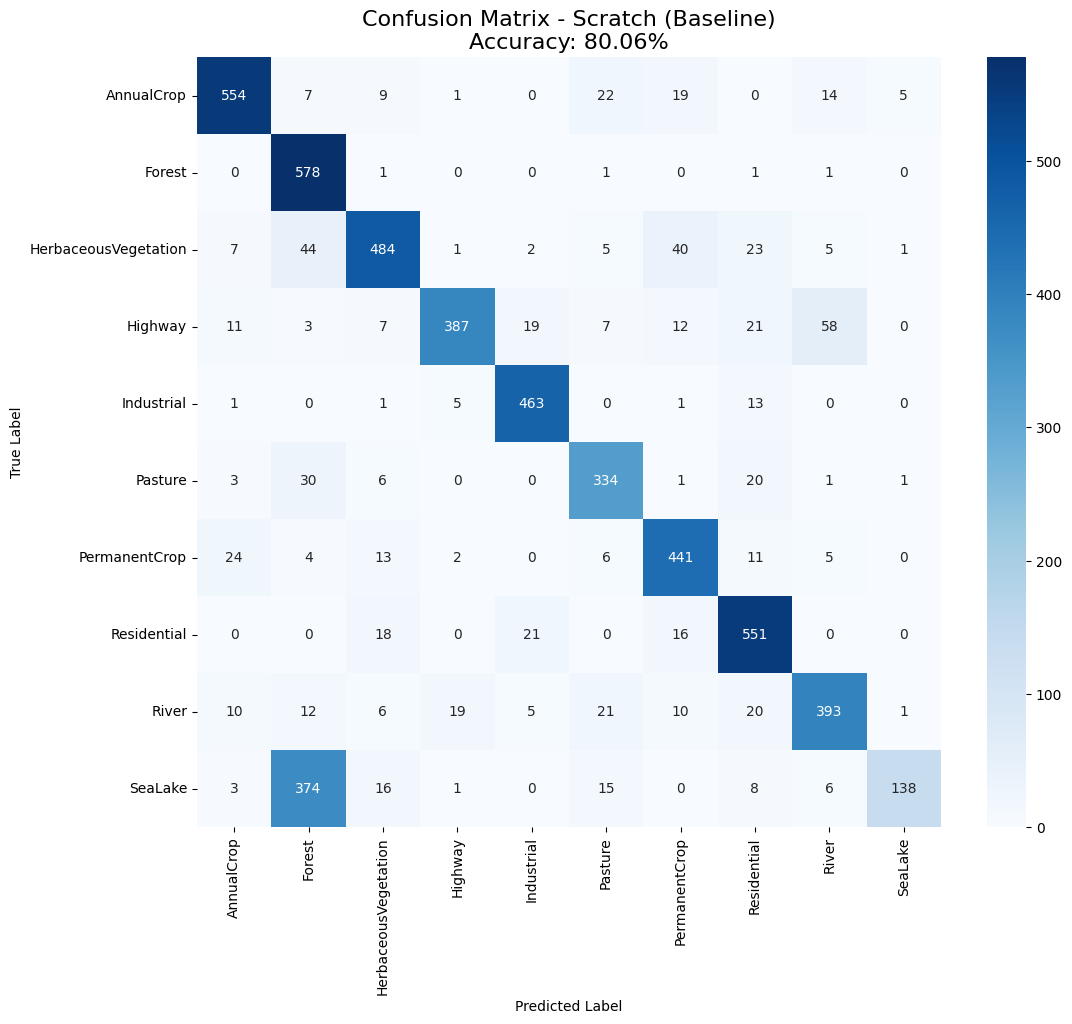

Computing t-SNE for Scratch (Baseline)...


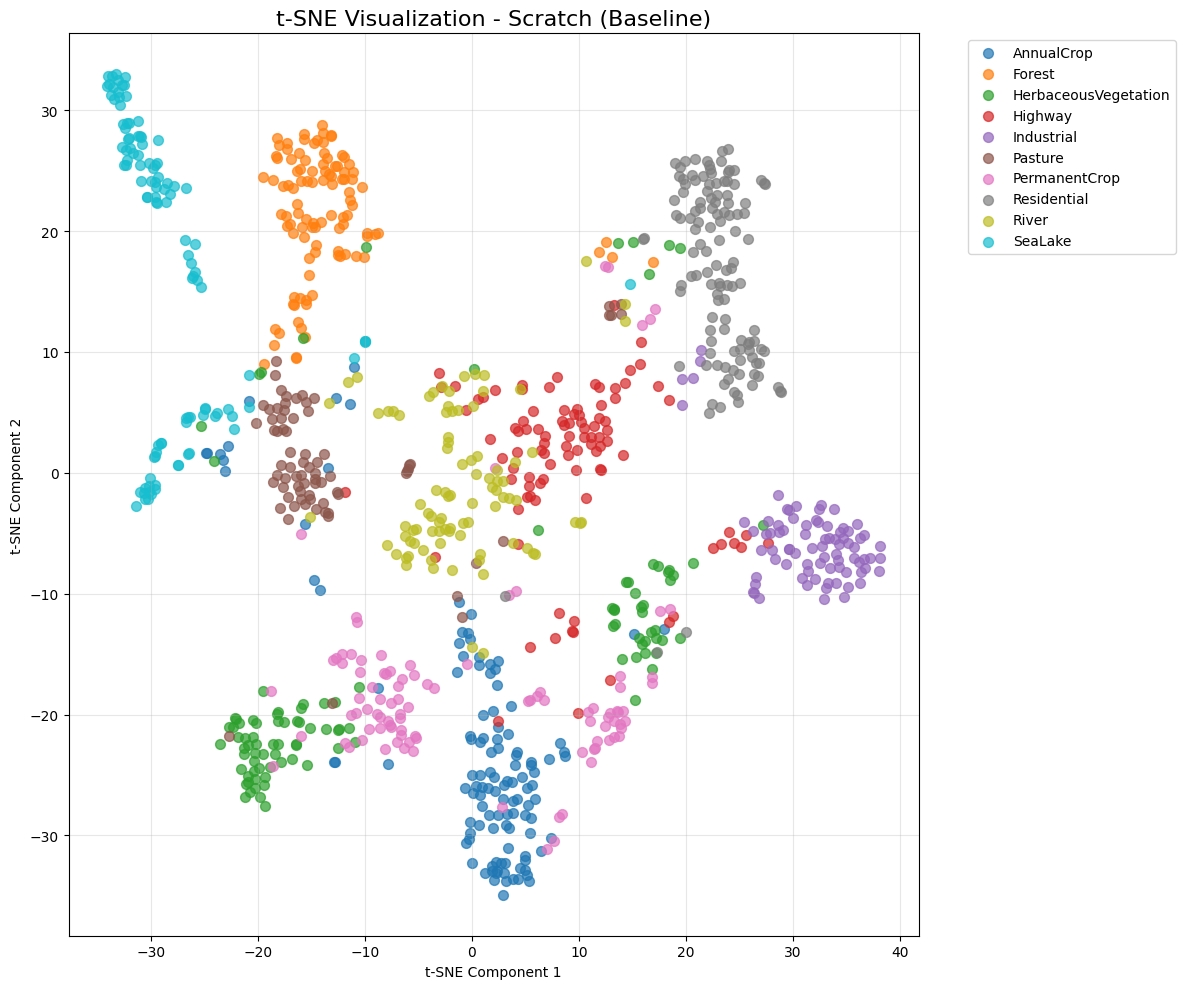


--- Evaluating BYOL ---
Loading pre-trained weights from: /kaggle/input/03-byol-training-50pct/byol_best_encoder_50pct.pth
Training Mode: Linear Probing (Encoder Frozen)
Starting training for 15 epochs...
  -> Epoch 1/15 - Test Accuracy: 77.07%
  -> Epoch 2/15 - Test Accuracy: 80.11%
  -> Epoch 3/15 - Test Accuracy: 81.00%
  -> Epoch 4/15 - Test Accuracy: 81.22%
  -> Epoch 5/15 - Test Accuracy: 82.37%
  -> Epoch 6/15 - Test Accuracy: 82.80%
  -> Epoch 7/15 - Test Accuracy: 83.63%
  -> Epoch 8/15 - Test Accuracy: 84.83%
  -> Epoch 9/15 - Test Accuracy: 82.81%
  -> Epoch 10/15 - Test Accuracy: 82.87%
  -> Epoch 11/15 - Test Accuracy: 82.41%
  -> Epoch 12/15 - Test Accuracy: 84.93%
  -> Epoch 13/15 - Test Accuracy: 84.70%
  -> Epoch 14/15 - Test Accuracy: 84.31%
  -> Epoch 15/15 - Test Accuracy: 81.44%

--- Detailed Report for: BYOL ---
Final Accuracy: 81.44%
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.91      0.86  

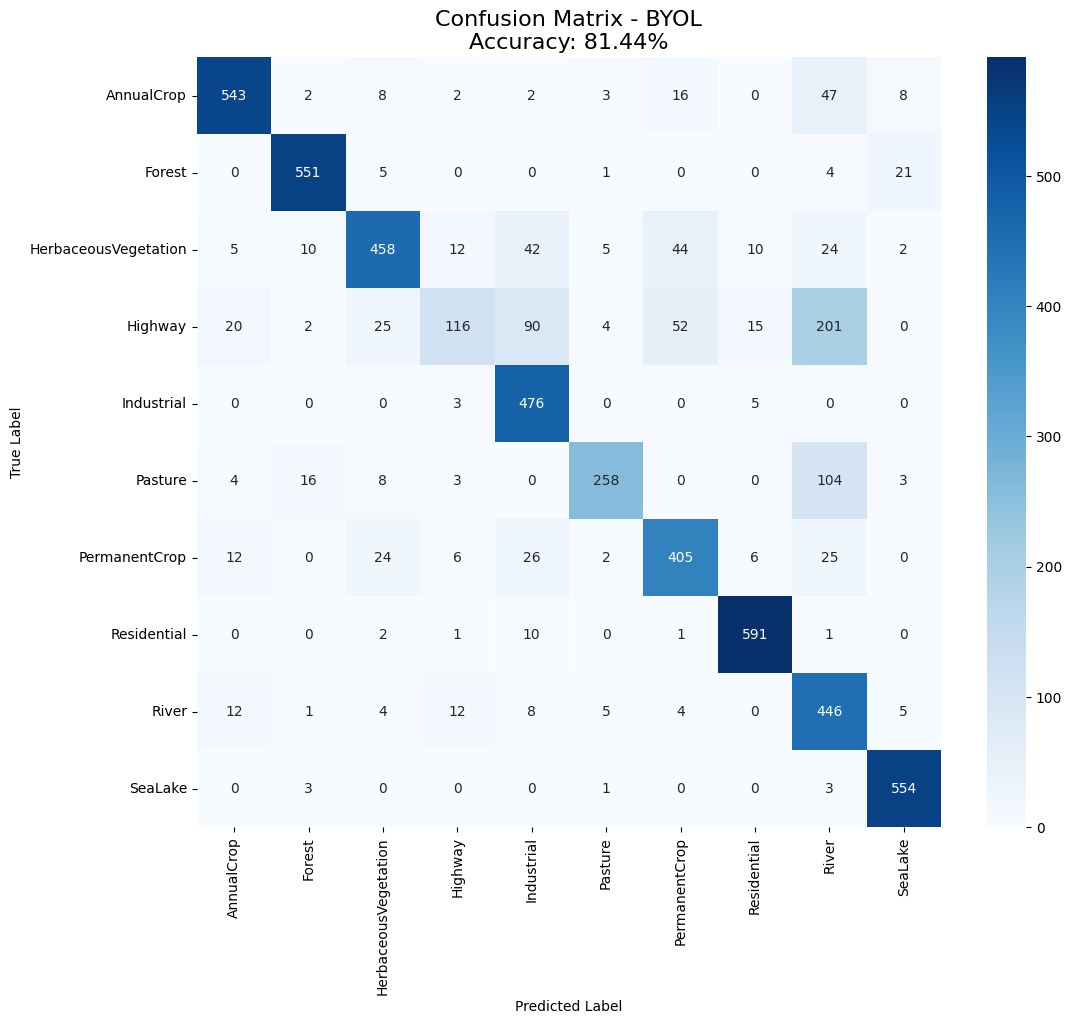

Computing t-SNE for BYOL...


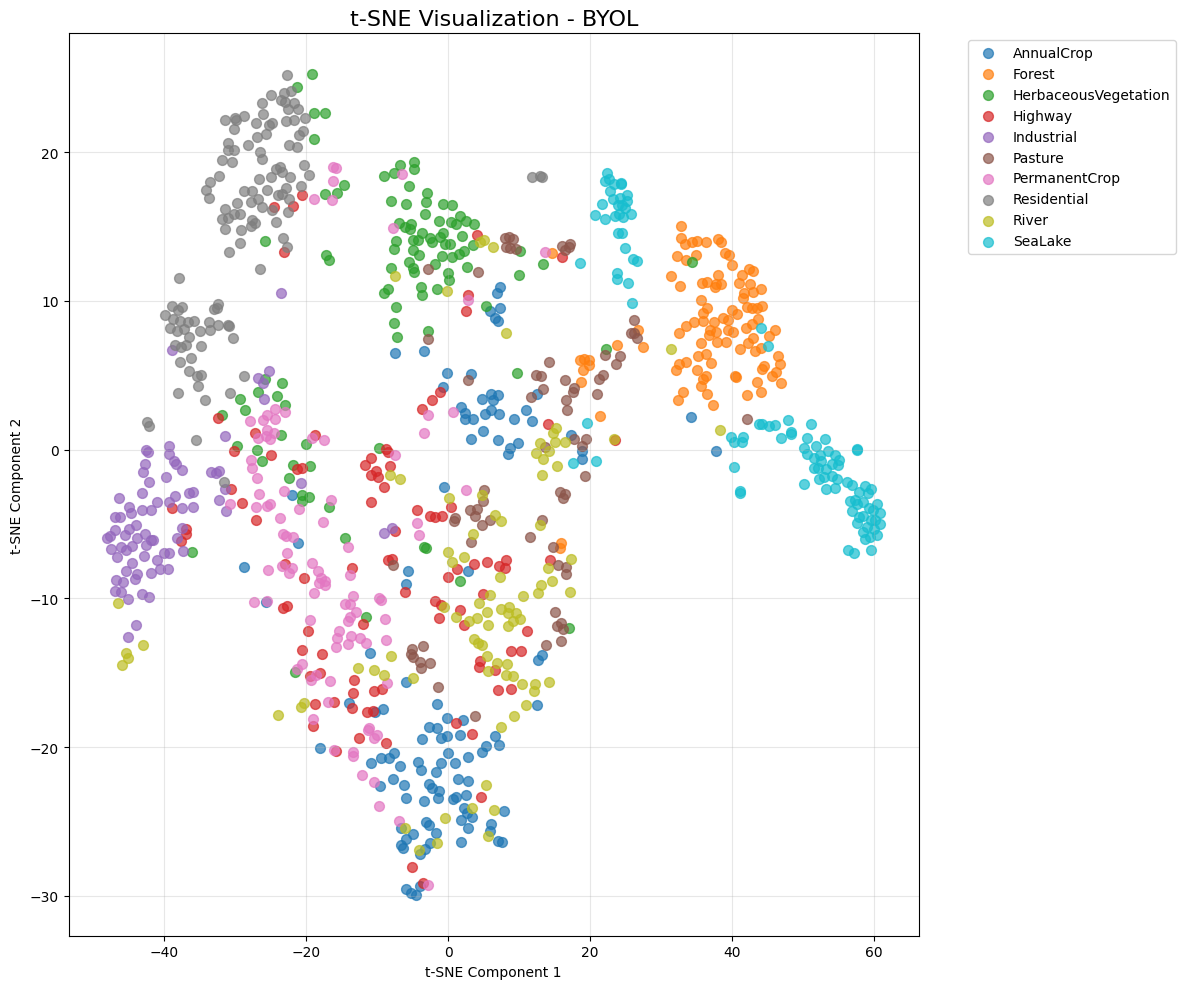


--- Evaluating Barlow Twins ---
Loading pre-trained weights from: /kaggle/input/04-barlow-twins-50pct-part3/barlow_best_encoder_50pct.pth
Training Mode: Linear Probing (Encoder Frozen)
Starting training for 15 epochs...
  -> Epoch 1/15 - Test Accuracy: 81.46%
  -> Epoch 2/15 - Test Accuracy: 86.80%
  -> Epoch 3/15 - Test Accuracy: 86.67%
  -> Epoch 4/15 - Test Accuracy: 86.65%
  -> Epoch 5/15 - Test Accuracy: 87.98%
  -> Epoch 6/15 - Test Accuracy: 86.98%
  -> Epoch 7/15 - Test Accuracy: 87.46%
  -> Epoch 8/15 - Test Accuracy: 88.11%
  -> Epoch 9/15 - Test Accuracy: 87.80%
  -> Epoch 10/15 - Test Accuracy: 87.56%
  -> Epoch 11/15 - Test Accuracy: 88.80%
  -> Epoch 12/15 - Test Accuracy: 88.31%
  -> Epoch 13/15 - Test Accuracy: 88.59%
  -> Epoch 14/15 - Test Accuracy: 88.02%
  -> Epoch 15/15 - Test Accuracy: 88.83%

--- Detailed Report for: Barlow Twins ---
Final Accuracy: 88.83%
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop

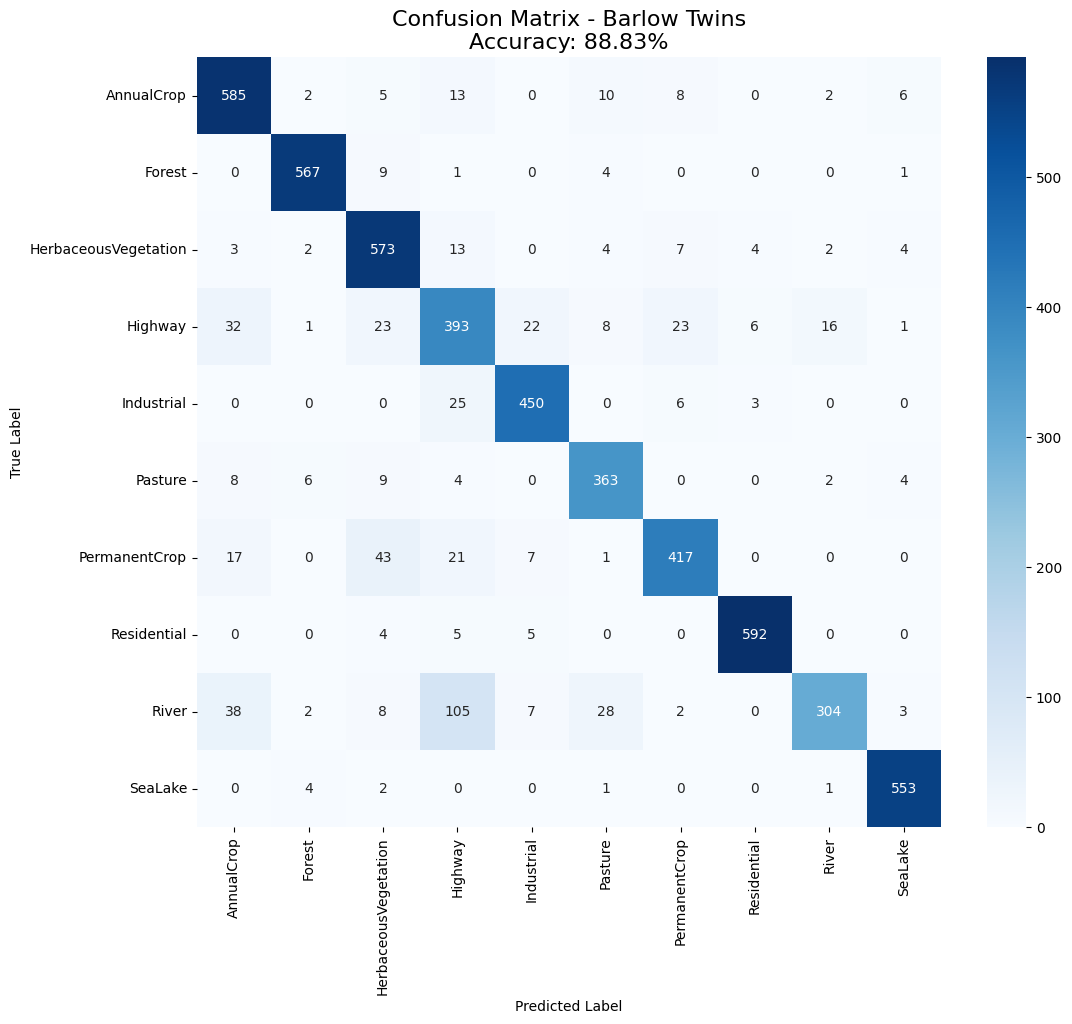

Computing t-SNE for Barlow Twins...


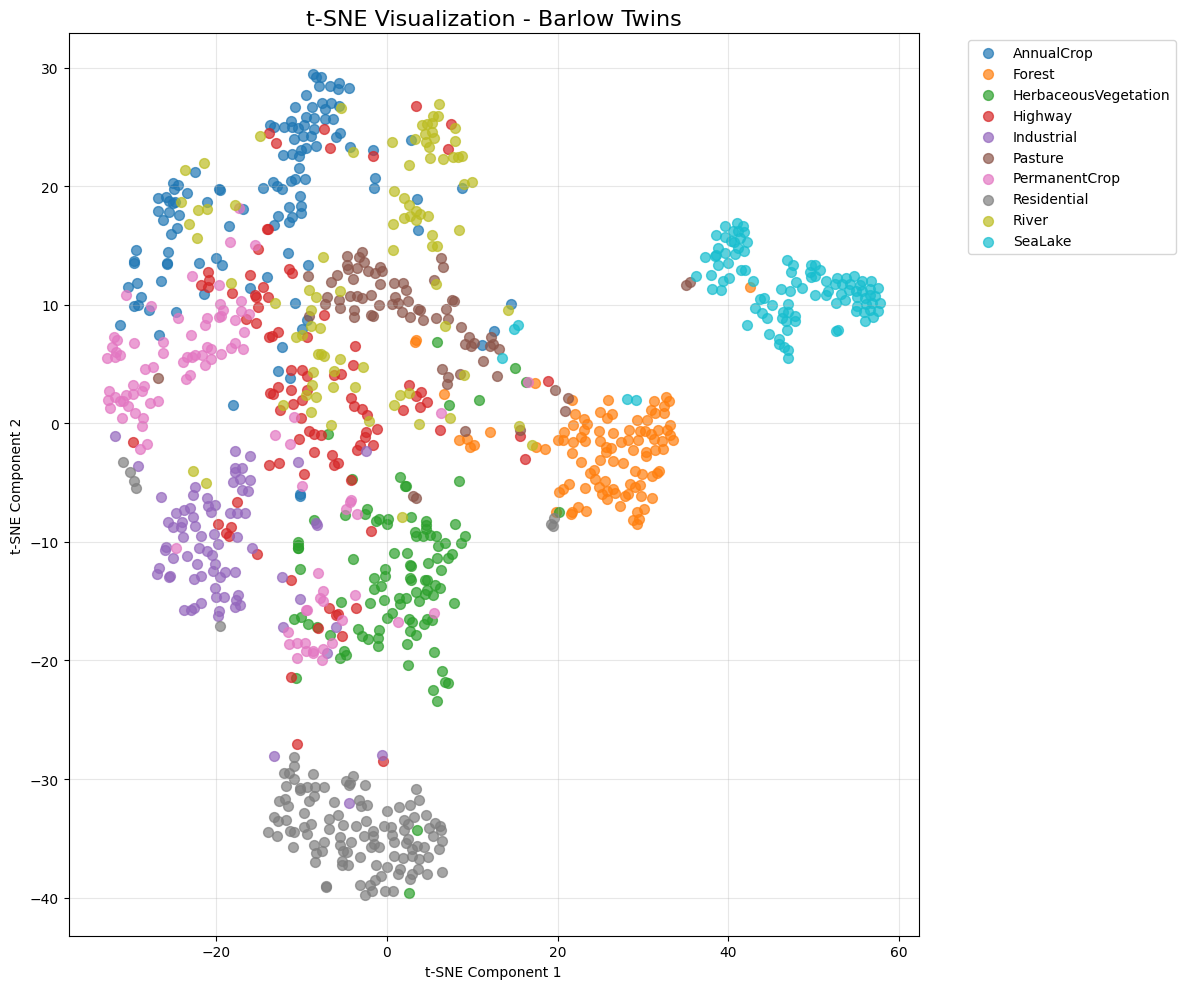



############################################################
#           FINAL ACCURACY RESULTS ON EUROSAT
############################################################
Barlow Twins             : 88.83%
BYOL                     : 81.44%
Scratch (Baseline)       : 80.06%
############################################################


In [1]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.datasets as datasets, torchvision.transforms as T, torchvision.models as models
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import os, gc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import pandas as pd

# --- 1. Configuration ---
CONFIG = {
    'byol_input_folder': '03-byol-training-50pct',
    'barlow_input_folder': '04-barlow-twins-50pct-part3',
    'byol_model_file': 'byol_best_encoder_50pct.pth',
    'barlow_model_file': 'barlow_best_encoder_50pct.pth',
    
    'epochs': 15,          # A single epoch count for all runs
    'batch_size': 256,
    'learning_rate': 0.01, # A single learning rate for all runs
    
    'num_classes': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 2,
}

# --- 2. EuroSAT Dataset ---
def get_eurosat_loaders(batch_size, num_workers):
    print("\n--- Preparing EuroSAT Dataset ---")
    transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
    dataset = datasets.EuroSAT(root='./data', download=True, transform=transform)
    train_size=int(0.8*len(dataset)); test_size=len(dataset)-train_size
    torch.manual_seed(42); train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
    print(f"EuroSAT loaded: {len(train_ds)} train, {len(test_ds)} test images.")
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers), DataLoader(test_ds, batch_size, shuffle=False, num_workers=num_workers), dataset.classes

# --- 3. Evaluation & Analysis Functions ---
def test_model(model, loader, device):
    model.eval(); all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device)); _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

def extract_features_for_tsne(model, loader, device, max_samples=1000):
    """Extract features from the model for t-SNE visualization"""
    model.eval()
    features, labels = [], []
    sample_count = 0
    
    with torch.no_grad():
        for images, batch_labels in loader:
            if sample_count >= max_samples:
                break
            
            images = images.to(device)
            batch_features = model(images)
            
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())
            
            sample_count += len(batch_labels)
    
    features = np.vstack(features)[:max_samples]
    labels = np.hstack(labels)[:max_samples]
    
    return features, labels

def plot_tsne(features, labels, class_names, model_name):
    """Create and plot t-SNE visualization"""
    print(f"Computing t-SNE for {model_name}...")
    
    # Compute t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_features = tsne.fit_transform(features)
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
    
    for i, class_name in enumerate(class_names):
        mask = labels == i
        plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], 
                   c=[colors[i]], label=class_name, alpha=0.7, s=50)
    
    plt.title(f't-SNE Visualization - {model_name}', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_evaluation(model, train_loader, test_loader, epochs, lr, device, is_probe):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Determine which parameters to train
    if is_probe:
        print("Training Mode: Linear Probing (Encoder Frozen)")
        optimizer = optim.Adam(model[1].parameters(), lr=lr) # Train only the classifier
    else:
        print("Training Mode: Full Model (From Scratch)")
        optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        if is_probe: model[0].eval()
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images); loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        
        y_true_temp, y_pred_temp = test_model(model, test_loader, device)
        acc = accuracy_score(y_true_temp, y_pred_temp) * 100
        print(f"  -> Epoch {epoch+1}/{epochs} - Test Accuracy: {acc:.2f}%")
        
    return test_model(model, test_loader, device)

def analyze_and_plot_results(model_name, y_true, y_pred, class_names, feature_extractor, test_loader, device):
    print(f"\n--- Detailed Report for: {model_name} ---")
    acc = accuracy_score(y_true, y_pred) * 100
    print(f"Final Accuracy: {acc:.2f}%")
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=2, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {acc:.2f}%', fontsize=16); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()
    
    # t-SNE Visualization
    features, labels = extract_features_for_tsne(feature_extractor, test_loader, device)
    plot_tsne(features, labels, class_names, model_name)

# --- 4. Main Execution ---
if __name__ == '__main__':
    device = torch.device(CONFIG['device']); print(f"Using device: {device}")
    train_loader, test_loader, class_names = get_eurosat_loaders(CONFIG['batch_size'], CONFIG['num_workers'])
    final_results = {}

    scenarios = {
        "Scratch (Baseline)": None,
        "BYOL": f"/kaggle/input/{CONFIG['byol_input_folder']}/{CONFIG['byol_model_file']}",
        "Barlow Twins": f"/kaggle/input/{CONFIG['barlow_input_folder']}/{CONFIG['barlow_model_file']}",
    }

    for name, path in scenarios.items():
        print("\n" + "="*60 + f"\n--- Evaluating {name} ---")
        
        encoder = models.resnet18(weights=None)
        
        if path: # This is for BYOL and Barlow Twins
            if not Path(path).exists():
                print(f"Model file not found: {path}. Skipping."); final_results[name] = "Not Found"; continue
            print(f"Loading pre-trained weights from: {path}")
            encoder.fc = nn.Identity()
            encoder.load_state_dict(torch.load(path, map_location=device))
            model_to_eval = nn.Sequential(encoder, nn.Linear(512, CONFIG['num_classes']))
            is_probe = True
        else: # This is for the Scratch model
            encoder.fc = nn.Linear(512, CONFIG['num_classes'])
            model_to_eval = encoder
            is_probe = False
            
        y_true, y_pred = run_evaluation(model_to_eval, train_loader, test_loader, CONFIG['epochs'], CONFIG['learning_rate'], device, is_probe)
        final_results[name] = accuracy_score(y_true, y_pred) * 100
        
        # For t-SNE, we need the feature extractor part
        feature_extractor = model_to_eval[0] if is_probe else model_to_eval
        if not is_probe: feature_extractor.fc = nn.Identity()
        analyze_and_plot_results(name, y_true, y_pred, class_names, feature_extractor, test_loader, device)
        gc.collect()

    # --- Final Summary Table ---
    print("\n\n" + "#"*60 + "\n#           FINAL ACCURACY RESULTS ON EUROSAT\n" + "#"*60)
    sorted_results = sorted(final_results.items(), key=lambda item: item[1] if isinstance(item[1], float) else -1, reverse=True)
    for model_name, acc in sorted_results:
        if isinstance(acc, float): print(f"{model_name:<25}: {acc:.2f}%")
        else: print(f"{model_name:<25}: {acc}")
    print("#"*60)